<a href="https://colab.research.google.com/github/uteyechea/DCGAN-Faces-Generator/blob/main/cifar10_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

### Setup

In [58]:
import tensorflow as tf

In [59]:
tf.__version__

'2.4.1'

In [60]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3gfqny4r
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-3gfqny4r
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01ee1b237a632139414f22f16e993535c2a48a68f_-cp36-none-any.whl size=147333 sha256=fb23a7a42cd91db643176806cc61812f291f8ec1eae1bb7f0333b742d45f0757
  Stored in directory: /tmp/pip-ephem-wheel-cache-yz562ac3/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [61]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the CIFAR10 dataset to train the generator and the discriminator. The generator will generate pictures resembling the 10 classes in the data.

In [62]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [63]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [64]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [65]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

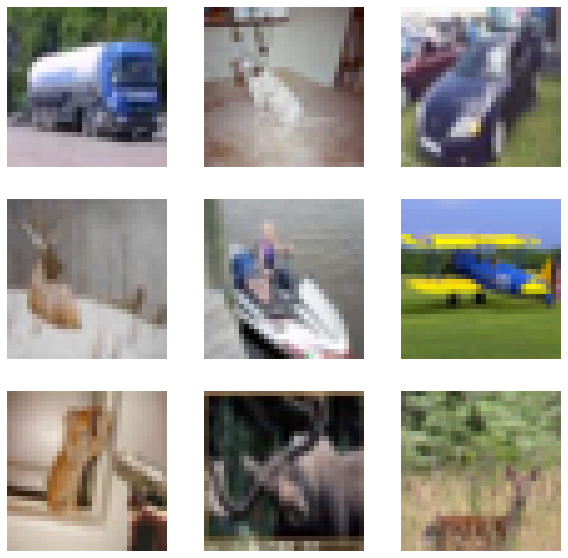

In [117]:
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1): #take(): Creates a Dataset with at most count elements from this dataset.
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*127.5+127.5).astype('int'))
    plt.axis("off")

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 32x32x3. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [67]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

Use the (as yet untrained) generator to create an image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


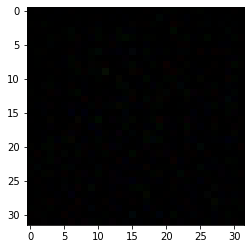

In [68]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [73]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [74]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[1.3930257e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [75]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [76]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [77]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [78]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [79]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [92]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [93]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [94]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [95]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i].numpy()*127.5+127.5).astype('int') )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real. After about n epochs, they resemble something real. 

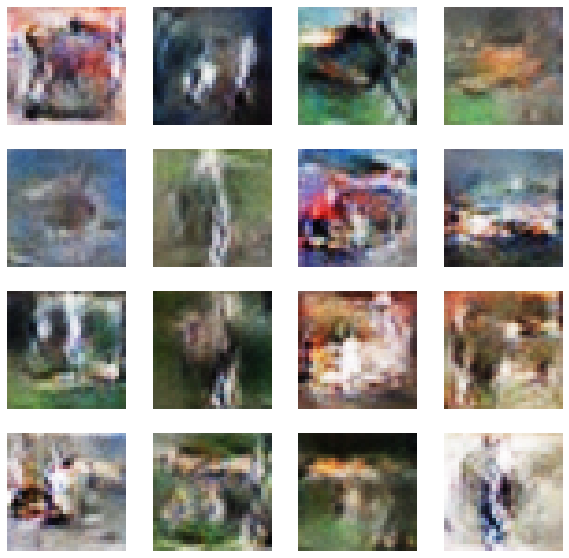

In [96]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [110]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [111]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

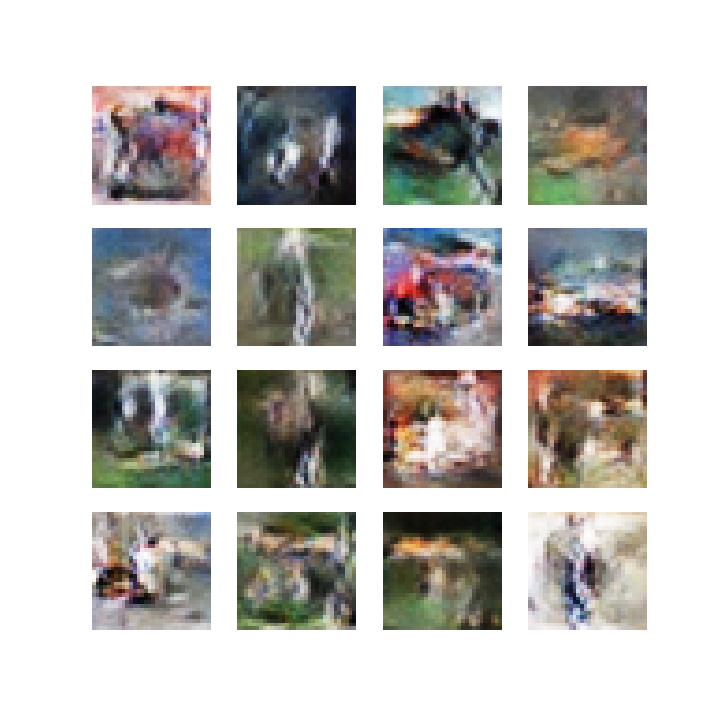

In [112]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [113]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [114]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)